# AI - Neural Networks

Name: amirhossein bagheri

Student ID: 98105621

## Install the requirements

In [2]:
!pip install -r requirements.txt

In [3]:
import hw4_helper
import torch.nn as nn
from sklearn.model_selection import train_test_split
from datetime import datetime
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random 

## Load train dataset
Note that the dataset will be downloaded in the `data_cache` directory for the first time. So do not remove that directory.

In [4]:

x_train, y_train = hw4_helper.get_train_data()
data_test = TensorDataset( Tensor(x_train),Tensor(y_train).type(torch.int32) )
train,valid = train_test_split(data_test, test_size=0.1)
batch_size = 512
missed_amount = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

100%|██████████| 293M/293M [00:03<00:00, 99.2MB/s]
100%|██████████| 766k/766k [00:00<00:00, 8.43MB/s]


device(type='cuda')

## Design your model

Write your neural network model below. Feel free to add extra cells.

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(4 * 4 * 128, 2000)
        self.fc2 = nn.Linear(2000, 1000)
        self.fc3 = nn.Linear(1000, 100)
        self.fc4 = nn.Linear(100, 10)
        self.convolution1 = nn.Sequential(
            nn.Conv2d(in_channels = 1 , out_channels= 32 ,kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.convolution2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.convolution3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out1 = nn.Dropout(p = 0.1 , inplace = True)
        self.drop_out2 = nn.Dropout(p = 0.45, inplace = True)
       
    def forward(self, x):
      out = self.convolution1(x)
      self.drop_out1(out)
      out = self.convolution2(out)
      self.drop_out1(out)
      out = self.convolution3(out)
      self.drop_out2(out)
      out = torch.flatten(out,start_dim=1)
      out = self.fc1(out)
      out = self.fc2(out)
      out = self.fc3(out)
      out = self.fc4(out)
      #out = self.softmax(out)
      return out

## Train your Model
Write the training proecss below. Fell free to add extra cells

In [7]:
#MODULE
model = Network()
model.to(device)

Network(
  (fc1): Linear(in_features=2048, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (convolution1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolution2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convolution3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out1): Dropout(p=0.1, inplace=True)
  (drop_out2): Dropout(p=0.45, inplace=True)
)

In [8]:
# loss function and optimaze and initilize parameters
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=True)
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
size = len(train)
size_v = len(valid)
def optimize():
    loss_amount = 0 
    accuracy_amount = 0
    for i,data in enumerate(train_loader,0): #train model by datas
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze_(1)).to(device)
        loss = criterion(outputs, labels.type(torch.LongTensor).to(device))
        loss_amount += loss.item()
        loss.backward() 
        optimizer.step()
        predicted = torch.argmax(outputs.data, 1).to(device)
        accuracy_amount += (predicted == labels).float().sum().item()
    return loss_amount,accuracy_amount
def test_validationSet():
    loss_amount = 0 
    accuracy_amount = 0
    for i,data in enumerate(valid_loader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs.unsqueeze_(1)).to(device)
        loss = criterion(outputs, labels.type(torch.LongTensor).to(device))
        loss_amount += loss.item()
        predicted = torch.argmax(outputs.data, 1).to(device)
        accuracy_amount += (predicted == labels).float().sum().item()
    return loss_amount,accuracy_amount
    

In [9]:
start_time = datetime.now()
print("epochs : ")
for epoch in range(100):  # loop over the dataset multiple times
    #train
    loss_amount,accuracy_amount = optimize()
    train_loss.append(loss_amount)
    train_accuracy.append(100*accuracy_amount/size)
    #validation test:
    loss_amount,accuracy_amount = test_validationSet()    
    valid_loss.append(loss_amount)
    valid_accuracy.append(100*accuracy_amount/size_v)
    print(epoch,end=" ")
    if (epoch+1) % 25 == 0:
      print("")
end_time = datetime.now()
print("train accuracy : " ,np.round(train_accuracy[epoch]))
print("train loss: ",train_loss[epoch])
print("")
print("valid accuracy : " ,valid_accuracy[epoch])
print("valid loss: ",valid_loss[epoch])
print("total time including training and validation : " , end_time - start_time)
    
    


epochs : 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 
25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 
75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
train accuracy :  99.0
train loss:  5.935361601412296

valid accuracy :  96.45918367346938
valid loss:  3.20809543132782
total time including training and validation :  0:12:10.657368


## Draw the training curves
Draw two diagrams for train and validation, one showing loss of each epoch, and another showing accuracy of each epoch.

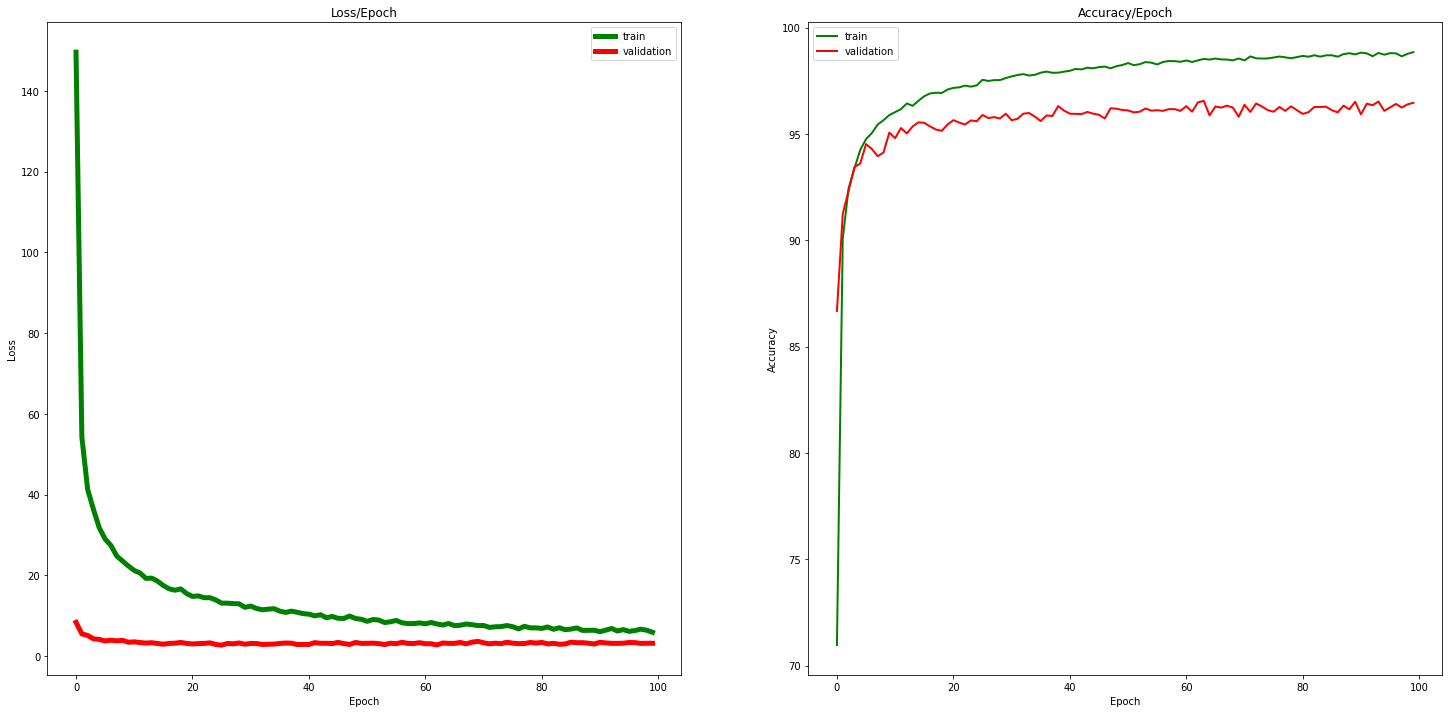

In [10]:
range_epoch = range(100)
fig, (ax1, ax2) = plt.subplots(1,2 )
fig.set_size_inches(25,12)
ax1.plot(range_epoch, train_loss , color = "green", linewidth=5, label = "train")
ax1.plot(range_epoch, valid_loss , color = "red",linewidth = 5, label = "validation")
ax1.title.set_text("Loss/Epoch")
ax1.set_xlabel('Epoch')
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(range_epoch, train_accuracy,color  = "green",linewidth = 2 , label = "train")
ax2.plot(range_epoch, valid_accuracy, color  = "red",linewidth = 2 , label = "validation")
ax2.title.set_text("Accuracy/Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()

## Draw misclassified images
Draw 10 misclassified images from validation set with expected and predicted labels

In [11]:
import sys
accuracy_amount = 0
bad_prediction = []
valid_loader = DataLoader(dataset=valid, batch_size=1, shuffle=False)
for i,data in enumerate(valid_loader,0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs.unsqueeze_(1)).to(device)
    predicted = torch.argmax(outputs.data, 1).to(device)
    amount= (predicted == labels).float().sum().item()
    accuracy_amount += amount
    if amount == 0:
      bad_prediction.append((inputs , labels,predicted))
print("accuracy = ",100*accuracy_amount/size_v)

accuracy =  96.35714285714286


<Figure size 432x288 with 0 Axes>

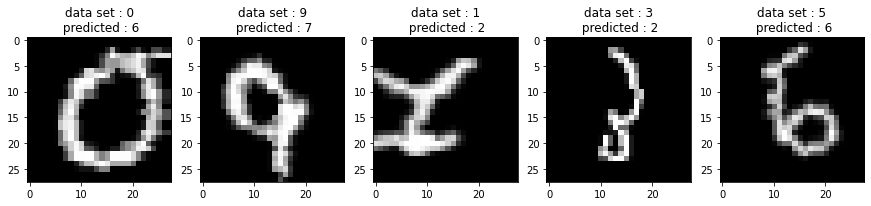

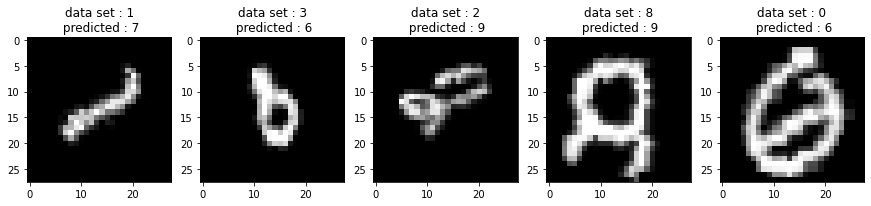

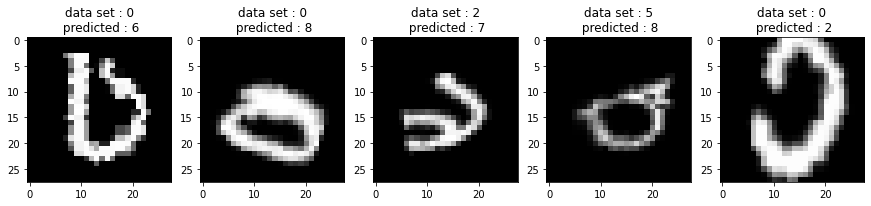

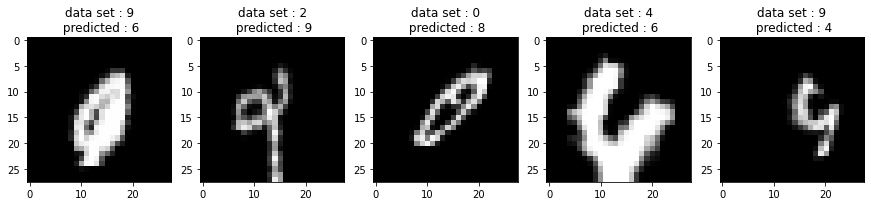

In [12]:
images = random.choices(bad_prediction , k = missed_amount)
images_d = []
for i in images:
  image , num , predicted = i
  image = image.cpu().numpy()[0,0,:,:]
  images_d.append(((image * 225).astype(np.uint8),num.item(),predicted.item()))
plt.gray()
for i in range(len(images_d) // 5):
  fig, axes = plt.subplots(1,5 )
  fig.set_size_inches(15,10)
  for j in range(5):
    #fig.add_subplot(1, 5, j+1)
    if 5*i + j >= len(images_d):
      break
    image , num ,pre = images_d[5*i + j]
    axes[j].imshow(Image.fromarray(image, 'L'))
    axes[j].title.set_text("data set : "+str(num) + "\n predicted : "+ str(pre))


  

## Evaluate your model on the test dataset

### Load test dataset
Note that the dataset will be downloaded for hte first time in the `data_cache` directory. So do not remove that directory.

In [13]:
x_test = hw4_helper.get_test_data()

100%|██████████| 62.8M/62.8M [00:00<00:00, 75.8MB/s]


### Run your model on test data

In [15]:
prediction = []
loader = DataLoader(dataset=x_test, batch_size=1, shuffle=False)
for i,data in enumerate(loader,0):
  input = data.to(device)
  outputs = model(data.unsqueeze_(1).to(device)).to(device)
  predicted = torch.argmax(outputs.data, 1).to(device)
  prediction.append(predicted.item())
prediction = np.array(prediction)


### Save the predictions
The following helper function will save the given prediction array (as a 1D numpy array) to `prediction.npy`. Upload this file with this notebook to quera as a `zip` file.

In [19]:
hw4_helper.export_prediction(prediction)

### Evaluate your predictions
The following helper function calls the test API with the given prediction array (as a 1D numpy array) and prints the server result.

In [20]:
hw4_helper.test(prediction)

Status: 200 - message: Your accuracy is 96.50%.
